<a href="https://colab.research.google.com/github/karthajee/minivggnet/blob/master/Stat_Ch14_MiniVGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Imports for getting the data ready
from tensorflow.keras.datasets import cifar10
from sklearn.preprocessing import LabelBinarizer
import tensorflow.keras.backend as K

#Imports for building MiniVGGNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

#Imports for training MiniVGGNet
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler

#Imports for evaluating MiniVGGNet
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

#Imports for other purposes
import numpy as np

In [7]:
#Define the custom learning rate function using equation-based step decay approach
def step_decay(epoch):
  
  #Initiaze terms in the equation
  alphaInit = 0.01
  dropFactor = 0.5
  dropEvery = 5

  #Compute the learning rate for the next epoch
  alphaNext = alphaInit * (dropFactor ** np.floor((1 + epoch)/dropEvery))

  #Return this learning rate to the calling function
  return float(alphaNext)

In [3]:
#Generate the train and test sets
(trainX, trainY),(testX, testY) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [4]:
#Store target classes in a list for later use
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#Normalize training & test input distributions
trainX = trainX.astype('float') / 255.0
testX = testX.astype('float') / 255.0

#Convert training & test target labels into one-hot vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

#Set channel dimension to -1 for BN layer
chanDim = -1

#Reshape both train and test input features according to channels ordering
if K.image_data_format() == 'channels_first':
  trainX = trainX.reshape(trainX.shape[0], trainX.shape[3], trainX.shape[1], trainX.shape[2])
  testX = testX.reshape(testX.shape[0], testX.shape[3], testX.shape[1], testX.shape[2])
  chanDim = 1

In [5]:
#Instantiate a Keras Sequential Model
model = Sequential()
inputShape = (trainX.shape[1], trainX.shape[2], trainX.shape[3])

#Build MiniVGGNet by stacking layers - one-by-one
print("[INFO] Building the model...")
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same', input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid'))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid'))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Dropout(rate=0.5))
model.add(Dense(units=len(labels), activation='softmax'))

#Print model summary
model.summary()

[INFO] Building the model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D

In [8]:
#Compiling the model
print("[INFO] Compiling the model...")
callbacks = [LearningRateScheduler(step_decay)]
opt = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

#Training the network
print('[INFO] Training the network...')
H = model.fit(trainX, trainY, batch_size=64, epochs=50, verbose=1, validation_data=(testX, testY), callbacks=callbacks)

[INFO] Compiling the model...
[INFO] Training the network...
Epoch 1/50
782/782 [==============================] - 6s 8ms/step - loss: 1.7629 - accuracy: 0.4172 - val_loss: 1.4833 - val_accuracy: 0.4734 - lr: 0.0100
Epoch 2/50
782/782 [==============================] - 6s 7ms/step - loss: 1.2789 - accuracy: 0.5586 - val_loss: 1.0381 - val_accuracy: 0.6323 - lr: 0.0100
Epoch 3/50
782/782 [==============================] - 6s 7ms/step - loss: 1.0628 - accuracy: 0.6301 - val_loss: 0.8852 - val_accuracy: 0.6941 - lr: 0.0100
Epoch 4/50
782/782 [==============================] - 6s 7ms/step - loss: 0.9340 - accuracy: 0.6767 - val_loss: 0.7956 - val_accuracy: 0.7212 - lr: 0.0100
Epoch 5/50
782/782 [==============================] - 6s 7ms/step - loss: 0.7813 - accuracy: 0.7247 - val_loss: 0.7146 - val_accuracy: 0.7469 - lr: 0.0050
Epoch 6/50
782/782 [==============================] - 6s 7ms/step - loss: 0.7280 - accuracy: 0.7429 - val_loss: 0.6690 - val_accuracy: 0.7652 - lr: 0.0050
Epoch 7/5

In [9]:
#Generate predictions on the test set
predictions = model.predict(testX, batch_size=64)

#Print the classification report
print(classification_report(y_true=np.argmax(testY, axis=1), y_pred=np.argmax(predictions, axis=1), 
                            target_names=labels))

              precision    recall  f1-score   support

    airplane       0.83      0.82      0.83      1000
  automobile       0.91      0.91      0.91      1000
        bird       0.78      0.70      0.74      1000
         cat       0.65      0.63      0.64      1000
        deer       0.77      0.80      0.78      1000
         dog       0.72      0.73      0.72      1000
        frog       0.84      0.89      0.86      1000
       horse       0.85      0.86      0.86      1000
        ship       0.91      0.91      0.91      1000
       truck       0.88      0.89      0.89      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



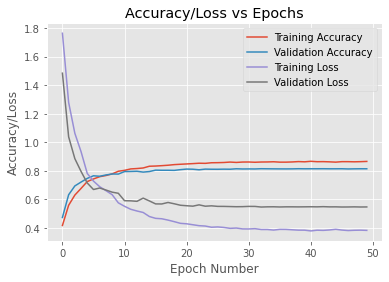

In [10]:
#Plot the training & validation loss/accuracy curve
plt.figure()
plt.style.use('ggplot')
plt.plot(np.arange(0, 50), H.history['accuracy'], label='Training Accuracy')
plt.plot(np.arange(0, 50), H.history['val_accuracy'], label='Validation Accuracy')
plt.plot(np.arange(0, 50), H.history['loss'], label='Training Loss')
plt.plot(np.arange(0, 50), H.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Accuracy/Loss vs Epochs')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy/Loss')
plt.show()